## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [37]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.9 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [38]:
!pip install textblob

In [39]:
import spacy 

In [40]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [41]:
# load data 
# ----------
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(n=1000, random_state=42)

congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,"RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. https://twitter.com/politico/status/1250764214433611784 QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026",Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670"
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum on the #GOPTaxLaw http://pbs.twimg.com/media/Dz0DJyKWsAAT3FZ.jpg http://pbs.twimg.com/media/Dz0DJyKXgAAyc6N.jpg http://pbs.twimg.com/media/Dz0DJyLWkAUzD4L.jpg,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,"RT @RepFilemonVela #Dreamers &amp; TPS recipients are essential members of communities across the country, working &amp; living alongside us all. We won’t let them be torn away from our communities. #ProtectTheDream #HR6 http://pbs.twimg.com/media/D1d_bWEWoAEOLrz.png",Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackCaucus @CAPAC @ExpressScripts @OptumRx @UnitedHealthGrp These CEOS represent 2 of the largest Pharmacy Benefit Managers (PBMs) in the US and are key players in the rising cost of insulin. We are hoping for a productive discussion as we all work to ensure that Americans have the #insulin they need at affordable prices. #Insulin4All,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843"
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today in the face of yet another extreme weather system. The close collaboration we see among all levels of government is exactly what need in times like need to ensure our residents are safe and prepared for tomorrow’s windstorm. http://pbs.twimg.com/media/D0HETHJWkAEM1IZ.jpg,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [42]:
pd.set_option('display.max_colwidth', None)
print(congress_tweets['text'].head(40))


908961                                              RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. https://twitter.com/politico/status/1250764214433611784 QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026
175615                                                                                                                                                                                                                                                                                                                                                       

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [43]:
text = congress_tweets['text']
text

908961    RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. https://twitter.com/politico/status/1250764214433611784 QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026
175615                                                                                                                                                                                                                                                                                                                                                                                                 

In [50]:
def rem_punc_stop(text):
    
    custom_stop_words = {"RT", "@","https", "jpg", "QT", "amp"}  # Specify additional stop words 
    stop_words = STOP_WORDS.union(custom_stop_words)  

    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [51]:
# initalize an empty list
tokens_reduced = []
# apply our new function to our text object from above
tokens_reduced = rem_punc_stop(text)

# view the first 5 tokens
tokens_reduced[0:5]

['@RepKClark', '22', 'million', 'Americans', 'filed']

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: Word Clouds

In [55]:
!pip install wordcloud

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#### 1) All tweets

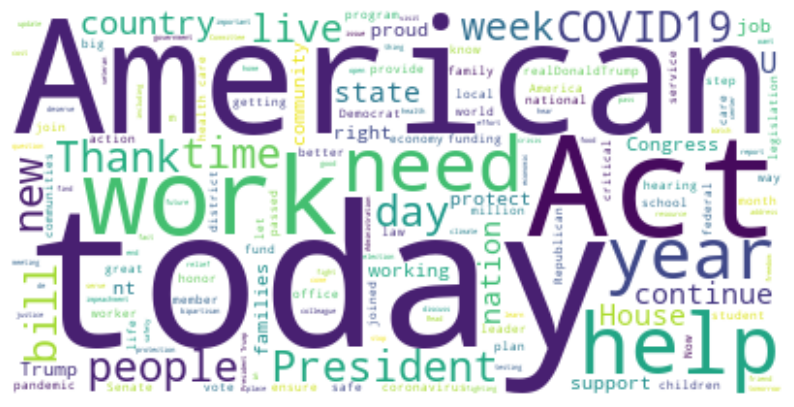

In [52]:
# need to do preprocessing again and re-create "tokens" column
congress_tweets['processed_tokens'] = congress_tweets['text'].apply(rem_punc_stop)

# apply function to text object
preprocessed_text = ' '.join([' '.join(tokens) for tokens in congress_tweets['processed_tokens']])

# create WordCloud visualization using the "text" object 
wordcloud = WordCloud(background_color="white", random_state=42).generate(preprocessed_text)

# Plot
plt.figure(figsize=(10, 7))  # Optional: Adjusts the size of the figure for better visibility
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axes to remove numerical labels on the sides
plt.show()


#### 2) Just Republican tweets

/var/folders/82/y3h5_5bj63g89f1zqt9sny1c0000gn/T/ipykernel_73109/288000718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  republicans_tweets['processed_tokens'] = republicans_tweets['text'].apply(rem_punc_stop)
/var/folders/82/y3h5_5bj63g89f1zqt9sny1c0000gn/T/ipykernel_73109/288000718.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  democrats_tweets['processed_tokens'] = democrats_tweets['text'].apply(rem_punc_stop)


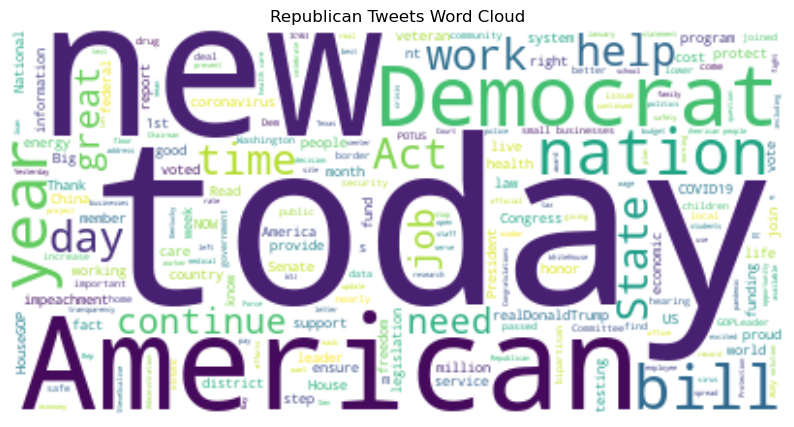

In [53]:
# Filter the dataset into two subsets
republicans_tweets = congress_tweets[congress_tweets['party'] == 'Republican']
democrats_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']

# preprocessing 
republicans_tweets['processed_tokens'] = republicans_tweets['text'].apply(rem_punc_stop)
democrats_tweets['processed_tokens'] = democrats_tweets['text'].apply(rem_punc_stop)

# combine tokens into single strings 
republicans_text = ' '.join([' '.join(tokens) for tokens in republicans_tweets['processed_tokens']])
democrats_text = ' '.join([' '.join(tokens) for tokens in democrats_tweets['processed_tokens']])

# plot for Republicans
wordcloud_republicans = WordCloud(background_color="white", random_state=42).generate(republicans_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_republicans, interpolation='bilinear')
plt.title('Republican Tweets Word Cloud')
plt.axis('off')
plt.show()




#### 3) Just Democrat tweets

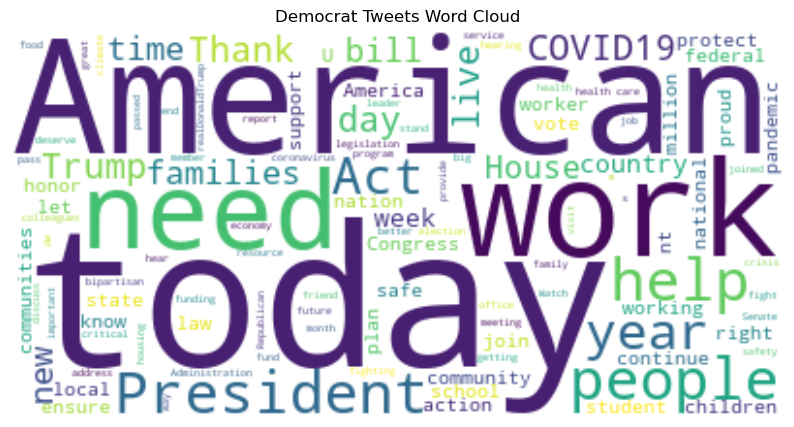

In [54]:
# plot for Democrats
wordcloud_democrats = WordCloud(background_color="white", random_state=42).generate(democrats_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_democrats, interpolation='bilinear')
plt.title('Democrat Tweets Word Cloud')
plt.axis('off')
plt.show()


### EDA 2: Common words by count (Representatives vs. Senators)

In [57]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,processed_tokens
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,"RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. https://twitter.com/politico/status/1250764214433611784 QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026",Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,7,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[RepKClark, 22, million, Americans, filed, unemployment, 4, weeks, We, need, find, innovative, solutions, act, fast, That, s, I, support, PaycheckGuaranteeAct, cover, 100, wages, workers, earning, 100k, ensure, workers, healthcare, politico, BREAKING, 52, million, Americans, applied, unemployment, week, In, weeks, 22, million, people, seeking, jobless, benefits]"
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum on the #GOPTaxLaw http://pbs.twimg.com/media/Dz0DJyKWsAAT3FZ.jpg http://pbs.twimg.com/media/Dz0DJyKXgAAyc6N.jpg http://pbs.twimg.com/media/Dz0DJyLWkAUzD4L.jpg,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892","[Thanks, came, tonight, forum, GOPTaxLaw]"
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,"RT @RepFilemonVela #Dreamers &amp; TPS recipients are essential members of communities across the country, working &amp; living alongside us all. We won’t let them be torn away from our communities. #ProtectTheDream #HR6 http://pbs.twimg.com/media/D1d_bWEWoAEOLrz.png",Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[RepFilemonVela, Dreamers, TPS, recipients, essential, members, communities, country, working, living, alongside, We, wo, let, torn, away, communities, ProtectTheDream, HR6]"
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackCaucus @CAPAC @ExpressScripts @OptumRx @UnitedHealthGrp These CEOS represent 2 of the largest Pharmacy Benefit Managers (PBMs) in the US and are key players in the rising cost of insulin. We are hoping for a productive discussion as we all work to ensure that Americans have the #insulin they need at affordable prices. #Insulin4All,Joaquín Castro,Rep,3-Jan-13,9/16/1974,M,TX,20,Democrat,"4,685,047","3,877,868","3,308,124","4,569,843","[HispanicCaucus, JoaquinCastrotx, TheBlackCaucus, CAPAC, ExpressScripts, OptumRx, UnitedHealthGrp, These, CEOS, represent, 2, largest, Pharmacy, Benefit, Managers, PBMs, US, key, players, rising, cost, insulin, We, hoping, productive, discussion, work, ensure, Americans, insulin, need, affordable, prices, Insulin4All]"
553399,1.099380e+18,RepJoeMorelle,2019-02-23T13:29:08-05:00,Thank you to @NYGovCuomo for being here today in the face of yet another extreme weather system. The close collaboration we see among all levels of government is exactly what need in times like need to ensure our residents are safe and prepared for tomorrow’s windstorm. http://pbs.twimg.com/media/D0HETHJWkAEM1IZ.jpg,Joseph D. Morelle,Rep,13-Nov-18,4/29/1957,M,NY,25,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[Thank, NYGovCuomo, today, face, extreme, weather, system, The, close, collaboration, levels, government, exactly, need, times, like, need, ensure, residents, safe, prepared, tomorrow, windstorm]"


In [58]:
unique_positions = congress_tweets['position'].unique()
print(unique_positions)


['Rep' 'Sen']


In [59]:
from collections import Counter

# Assuming 'congress_tweets' is your DataFrame and it has a column 'text' with tweet texts

# Pre-process tweets and return a flat list of words
def preprocess_and_get_words(df):
    all_words = []
    for tweet in df['text']:
        words = rem_punc_stop(tweet)  # Assuming rem_punc_stop returns a list of words
        all_words.extend(words)
    return all_words

# Filter dataset for Representatives and Senators
rep_tweets = congress_tweets[congress_tweets['position'] == 'Rep']
sen_tweets = congress_tweets[congress_tweets['position'] == 'Sen']

# Get pre-processed words
rep_words = preprocess_and_get_words(rep_tweets)
sen_words = preprocess_and_get_words(sen_tweets)

# Count the most common words
rep_word_count = Counter(rep_words)
sen_word_count = Counter(sen_words)

# Get the 3 most common words
rep_common_words = rep_word_count.most_common(3)
sen_common_words = sen_word_count.most_common(3)

print("3 Most Common Words in Tweets by Representatives:", rep_common_words)
print("3 Most Common Words in Tweets by Senators:", sen_common_words)


3 Most Common Words in Tweets by Representatives: [('\n\n', 303), ('I', 271), ('\n', 146)]
3 Most Common Words in Tweets by Senators: [('I', 90), ('\n\n', 80), ('The', 53)]


#### Result: similar words were common, but need to get rid of '\n\n' and '\n' as "words"

#### Trying again...

In [60]:
import pandas as pd
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

# reloading spacy stuff
nlp = spacy.load("en_core_web_sm")

# re-doing preprocessing to filter out \n and \n\n
def rem_punc_stop(text):
    custom_stop_words = {"RT", "@", "https", "jpg", "QT", "amp"}  # Custom stop words
    stop_words = STOP_WORDS.union(custom_stop_words)

    punc = set(punctuation)
    text = text.replace('\n', ' ')  # Replacing newline characters with space

    punc_free = "".join(ch for ch in text if ch not in punc)
    doc = nlp(punc_free.lower())  # Lowercasing to standardize

    filtered_tokens = [token.text for token in doc if token.text not in stop_words and len(token.text) > 1]
    return filtered_tokens


3 Most Common Words in Tweets by Representatives: [('rt', 216), ('today', 111), ('qt', 99)]
3 Most Common Words in Tweets by Senators: [('rt', 49), ('qt', 43), ('today', 29)]


In [61]:

# apply the preprocessing function to each tweet and aggregate by position
tweets_by_rep = " ".join(congress_tweets[congress_tweets['position'] == 'Rep']['text'].apply(rem_punc_stop).sum())
tweets_by_sen = " ".join(congress_tweets[congress_tweets['position'] == 'Sen']['text'].apply(rem_punc_stop).sum())

# Count the most common words
most_common_words_rep = Counter(tweets_by_rep.split()).most_common(3)
most_common_words_sen = Counter(tweets_by_sen.split()).most_common(3)

print("3 Most Common Words in Tweets by Representatives:", most_common_words_rep)
print("3 Most Common Words in Tweets by Senators:", most_common_words_sen)


3 Most Common Words in Tweets by Representatives: [('rt', 216), ('today', 111), ('qt', 99)]
3 Most Common Words in Tweets by Senators: [('rt', 49), ('qt', 43), ('today', 29)]


#### Result: Representatives and Senators used many of the same words. Representative counts are higher because there are more politicians in the House of Representatives.

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

Note: before reading this, I already did (1) Democrats v. Republicans and (2) Senators v. Representatives in the EDA above, so I am just going to create a density plot of Democrats vs. Republicans and then Senators v. Representatives

`TextBlob` has already been imported in the top cell.

### 1) Two legislators: One liberal and one conservative

In [62]:

# Randomly select a screen_name from a Republican and a Democrat
rep_screen_name = congress_tweets[congress_tweets['party'] == 'Republican']['screen_name'].sample(1).iloc[0]
dem_screen_name = congress_tweets[congress_tweets['party'] == 'Democrat']['screen_name'].sample(1).iloc[0]

# Function to calculate sentiment polarity
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity


In [65]:
rep_screen_name

'GOPLeader'

In [66]:
dem_screen_name

'RepLoriTrahan'

/var/folders/82/y3h5_5bj63g89f1zqt9sny1c0000gn/T/ipykernel_73109/3175454061.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rep_sentiments, shade=True, color="r", label=f"Republican: {rep_screen_name}", alpha=0.5)
/var/folders/82/y3h5_5bj63g89f1zqt9sny1c0000gn/T/ipykernel_73109/3175454061.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dem_sentiments, shade=True, color="b", label=f"Democrat: {dem_screen_name}", alpha=0.5)


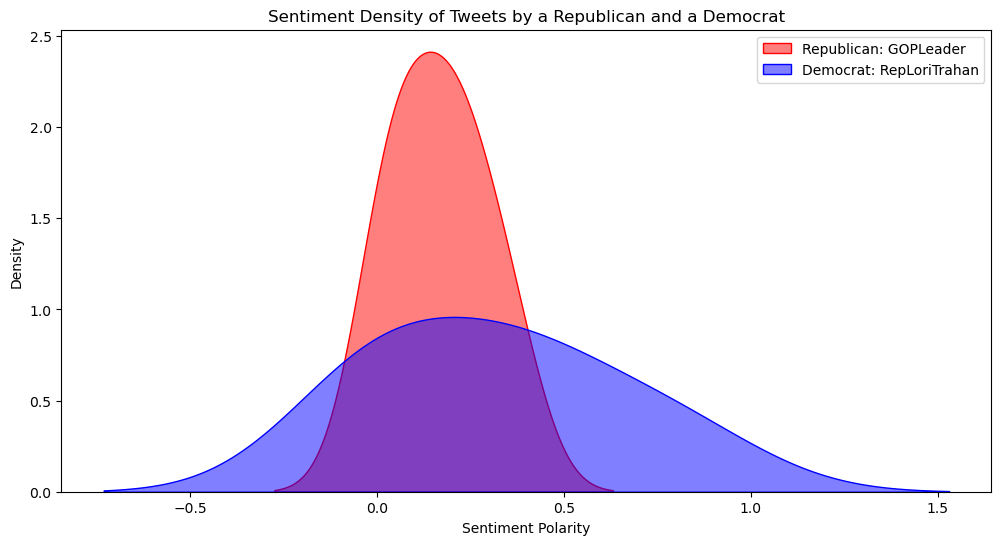

In [64]:

# Analyze the sentiment scores per tweet for each randomly selected legislator
rep_sentiments = congress_tweets[congress_tweets['screen_name'] == rep_screen_name]['text'].apply(calculate_sentiment)b
dem_sentiments = congress_tweets[congress_tweets['screen_name'] == dem_screen_name]['text'].apply(calculate_sentiment)

# Produce density plots for their sentiments
plt.figure(figsize=(12, 6))

sns.kdeplot(rep_sentiments, shade=True, color="r", label=f"Republican: {rep_screen_name}", alpha=0.5)
sns.kdeplot(dem_sentiments, shade=True, color="b", label=f"Democrat: {dem_screen_name}", alpha=0.5)

plt.title('Sentiment Density of Tweets by a Republican and a Democrat')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.legend()

plt.show()



#### Interpretation: the peaks show that both the Republican and Democrat were slightly skewed towards positive sentiment (around 0.2). The Democrat had a wider range in sentiment or variability between negative and positive sentiment (e.g., not as high of a peak).

### 2) Republicans vs. Democrats

/var/folders/82/y3h5_5bj63g89f1zqt9sny1c0000gn/T/ipykernel_73109/3718405503.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(republican_sentiments, shade=True, color="r", label="Republicans", alpha=0.5)
/var/folders/82/y3h5_5bj63g89f1zqt9sny1c0000gn/T/ipykernel_73109/3718405503.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(democrat_sentiments, shade=True, color="b", label="Democrats", alpha=0.5)


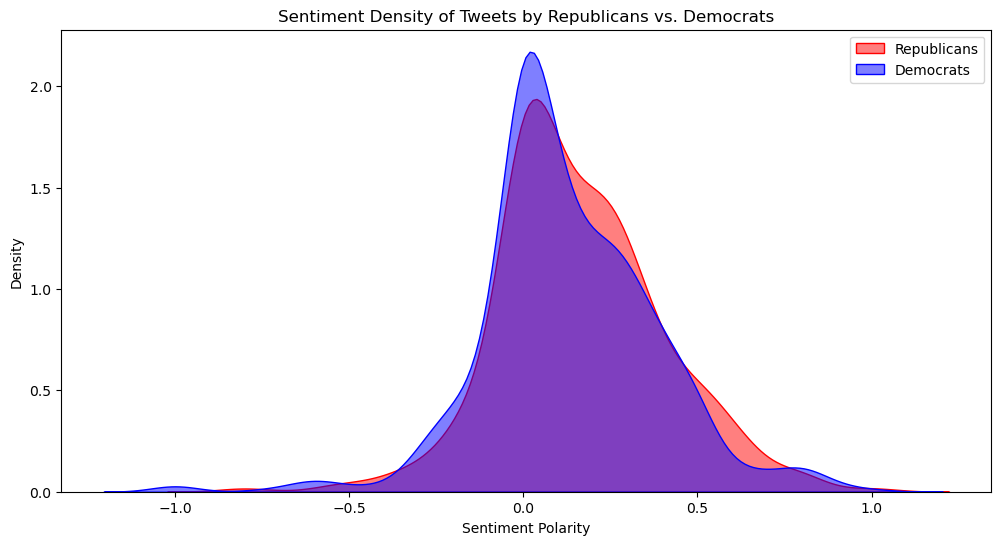

In [71]:
# calculate sentiment for each tweet
congress_tweets['sentiment'] = congress_tweets['text'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

# Filter by party & extract sentiments
republican_tweets = congress_tweets[congress_tweets['party'] == 'Republican']
democrat_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']

republican_sentiments = republican_tweets['sentiment']
democrat_sentiments = democrat_tweets['sentiment']

# density plots
plt.figure(figsize=(12, 6))

sns.kdeplot(republican_sentiments, shade=True, color="r", label="Republicans", alpha=0.5)
sns.kdeplot(democrat_sentiments, shade=True, color="b", label="Democrats", alpha=0.5)

plt.title('Sentiment Density of Tweets by Republicans vs. Democrats')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.legend()

plt.show()


#### Interpretation: Surprisingly similar, although the Republicans have slightly more positive sentiment tweets

### 3) Representatives vs. Senators

/var/folders/82/y3h5_5bj63g89f1zqt9sny1c0000gn/T/ipykernel_73109/1060985266.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(representatives_sentiments, shade=True, color="g", label="Representatives", alpha=0.5)
/var/folders/82/y3h5_5bj63g89f1zqt9sny1c0000gn/T/ipykernel_73109/1060985266.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(senators_sentiments, shade=True, color="m", label="Senators", alpha=0.5)


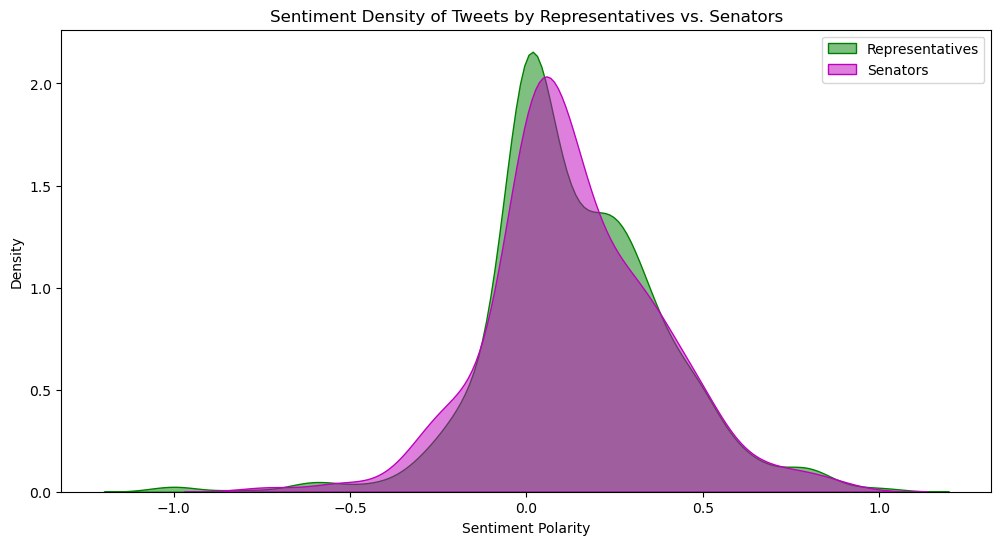

In [70]:
# Calculate sentiment for each tweet
congress_tweets['sentiment'] = congress_tweets['text'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

# filter by position & extract sentiments
representatives_tweets = congress_tweets[congress_tweets['position'] == 'Rep']
senators_tweets = congress_tweets[congress_tweets['position'] == 'Sen']

representatives_sentiments = representatives_tweets['sentiment']
senators_sentiments = senators_tweets['sentiment']

# Produce plots
plt.figure(figsize=(12, 6))

sns.kdeplot(representatives_sentiments, shade=True, color="g", label="Representatives", alpha=0.5)
sns.kdeplot(senators_sentiments, shade=True, color="m", label="Senators", alpha=0.5)

plt.title('Sentiment Density of Tweets by Representatives vs. Senators')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.legend()

plt.show()


#### Interpretation: Senators were slightly more positive and had more variability than Representatives, which kind of makes sense given their longer term

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [73]:
# want to calculate word count and sentiment score for each tweet
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(x.split()))
congress_tweets['sentiment_score'] = congress_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Creating dataframe
engineered_features_df = congress_tweets[['word_count', 'sentiment_score']]
engineered_features_df.head(20)

,word_count,sentiment_score
908961,74,0.240000
175615,15,0.200000
64613,33,0.000000
783091,56,0.000000
553399,47,0.208333
32238,32,0.250000
20570,41,0.000000
704089,50,0.109545
246925,30,-0.200000
267417,51,0.496591


### Bag-of-words or Tf-idf

In [76]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000)  # Limit to top 3000 features
tfidf_matrix = tfidf_vectorizer.fit_transform(congress_tweets['text'])

# showing dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head(10)

,00,000,01,02,03,04,05,06,07,08,...,young,your,yours,yourself,youth,youtu,youtube,yovanovitch,yrs,yuen
0,0.0,0.000000,0.0,0.0,0.0,0.103529,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.135408,0.0,0.0,0.0,0.150172,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.182714,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.123230,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [78]:
import numpy as np  

import gensim.downloader as api
from gensim.models import Word2Vec

# Load a pre-trained word2vec model
word2vec_model = api.load("glove-wiki-gigaword-100")  # using this instead 
                                                        # looked it up online, loads a smaller model

# average word embeddings for a document
def document_vector(doc):
    doc = [word for word in doc if word in word2vec_model.key_to_index] # Remove out-of-vocabulary words
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model[doc], axis=0)

# Tokenize 
congress_tweets['tokenized_text'] = congress_tweets['text'].apply(lambda x: x.split())  # Simple tokenizer

# Apply function 
embedding_features = np.array([document_vector(doc) for doc in congress_tweets['tokenized_text']])

# dataframe
embedding_features_df = pd.DataFrame(embedding_features)


In [79]:
embedding_features_df.head(20)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.127633,0.398251,0.176576,-0.146270,0.108966,-0.013217,-0.197971,0.247353,-0.202805,0.074816,...,0.038904,-0.018057,-0.161317,-0.146396,-0.606397,0.029694,-0.138590,-0.025936,0.679161,-0.108708
1,-0.069063,0.128270,0.365344,-0.344869,0.172380,0.174106,-0.249236,0.209870,-0.343901,-0.024707,...,-0.084225,-0.157314,-0.181836,0.067274,-0.607994,-0.005138,-0.274569,-0.198986,0.710213,0.185822
2,-0.093726,0.309786,0.269159,-0.284748,0.112319,0.195297,-0.354823,0.171363,-0.199118,0.019011,...,-0.142198,-0.184031,-0.012323,-0.032847,-0.675157,-0.106014,-0.179844,-0.091537,0.612968,0.252200
3,-0.136487,0.271174,0.302768,-0.111663,0.063048,0.015438,-0.205741,0.159262,-0.296446,0.007533,...,-0.101257,-0.055393,-0.201091,0.110285,-0.685356,-0.066676,-0.210771,-0.280608,0.735433,0.229686
4,-0.196243,0.260597,0.407908,-0.126511,-0.061301,0.120669,-0.299354,0.149101,-0.239651,0.013861,...,0.023860,-0.089041,-0.139933,0.077065,-0.635273,0.020541,-0.212418,-0.306639,0.536945,0.239070
5,0.033859,0.128660,0.023940,-0.097131,0.132318,-0.087421,-0.268288,0.246001,-0.189552,0.018527,...,-0.027210,-0.192903,-0.116290,-0.116722,-0.692480,0.011013,-0.139365,-0.175925,0.747493,0.073542
6,-0.018217,0.304730,0.207248,-0.199610,0.099737,-0.186198,-0.346963,0.164009,-0.154208,0.084429,...,-0.038088,-0.031302,-0.054803,-0.115840,-0.559468,-0.167319,-0.054506,-0.150664,0.690533,0.021761
7,-0.183322,0.067777,0.282359,-0.145690,0.132674,0.221574,-0.224589,0.165748,-0.287579,0.109835,...,0.074476,-0.129830,-0.251666,0.173999,-0.472673,0.017555,-0.273778,-0.251700,0.539526,0.219362
8,-0.118870,0.229334,0.294317,-0.221350,-0.194766,0.142654,-0.409951,0.134196,-0.117114,0.151295,...,-0.037890,-0.084555,0.058673,0.002705,-0.658222,-0.120418,-0.209019,-0.232008,0.570832,0.365358
9,-0.028204,0.232400,0.188621,-0.090209,0.038980,-0.176694,-0.145958,0.131727,-0.252071,0.000850,...,0.047905,0.018008,-0.088398,-0.029771,-0.683682,0.061312,0.037459,-0.121761,0.580478,0.107876


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

### 1) Engineered Text Features

#### *i think i already loaded the libraries but doing again just to make sure*

In [80]:
!pip install scikit-learn pandas numpy


In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


In [84]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,processed_tokens,sentiment,word_count,sentiment_score,tokenized_text
908961,1.250810e+18,RepJayapal,2020-04-16T11:31:24-04:00,"RT @RepKClark 22 million Americans filed for unemployment in the last 4 weeks. We need to find innovative solutions and to act fast. That's why I support the #PaycheckGuaranteeAct, which will cover 100% of wages for workers earning up to $100k and will ensure workers keep their #healthcare. https://twitter.com/politico/status/1250764214433611784 QT @politico BREAKING: 5.2 million Americans applied for unemployment last week. In four weeks alone, that’s more than 22 million people seeking jobless benefits. https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026",Pramila Jayapal,Rep,3-Jan-17,9/21/1965,F,WA,...,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[RepKClark, 22, million, Americans, filed, unemployment, 4, weeks, We, need, find, innovative, solutions, act, fast, That, s, I, support, PaycheckGuaranteeAct, cover, 100, wages, workers, earning, 100k, ensure, workers, healthcare, politico, BREAKING, 52, million, Americans, applied, unemployment, week, In, weeks, 22, million, people, seeking, jobless, benefits]",0.240000,74,0.240000,"[RT, @RepKClark, 22, million, Americans, filed, for, unemployment, in, the, last, 4, weeks., We, need, to, find, innovative, solutions, and, to, act, fast., That's, why, I, support, the, #PaycheckGuaranteeAct,, which, will, cover, 100%, of, wages, for, workers, earning, up, to, $100k, and, will, ensure, workers, keep, their, #healthcare., https://twitter.com/politico/status/1250764214433611784, QT, @politico, BREAKING:, 5.2, million, Americans, applied, for, unemployment, last, week., In, four, weeks, alone,, that’s, more, than, 22, million, people, seeking, jobless, benefits., https://www.politico.com/news/2020/04/16/coronavirus-unemployment-claims-numbers-190026]"
175615,1.098040e+18,RepJohnLarson,2019-02-19T20:51:22-05:00,Thanks to all who came out to tonight’s forum on the #GOPTaxLaw http://pbs.twimg.com/media/Dz0DJyKWsAAT3FZ.jpg http://pbs.twimg.com/media/Dz0DJyKXgAAyc6N.jpg http://pbs.twimg.com/media/Dz0DJyLWkAUzD4L.jpg,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,...,Democrat,"673,215","897,572","905,083","634,892","[Thanks, came, tonight, forum, GOPTaxLaw]",0.200000,15,0.200000,"[Thanks, to, all, who, came, out, to, tonight’s, forum, on, the, #GOPTaxLaw, http://pbs.twimg.com/media/Dz0DJyKWsAAT3FZ.jpg, http://pbs.twimg.com/media/Dz0DJyKXgAAyc6N.jpg, http://pbs.twimg.com/media/Dz0DJyLWkAUzD4L.jpg]"
64613,1.105510e+18,SpeakerPelosi,2019-03-12T12:55:01-04:00,"RT @RepFilemonVela #Dreamers &amp; TPS recipients are essential members of communities across the country, working &amp; living alongside us all. We won’t let them be torn away from our communities. #ProtectTheDream #HR6 http://pbs.twimg.com/media/D1d_bWEWoAEOLrz.png",Nancy Pelosi,Rep,2-Jun-87,3/26/1940,F,CA,...,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[RepFilemonVela, Dreamers, TPS, recipients, essential, members, communities, country, working, living, alongside, We, wo, let, torn, away, communities, ProtectTheDream, HR6]",0.000000,33,0.000000,"[RT, @RepFilemonVela, #Dreamers, &amp;, TPS, recipients, are, essential, members, of, communities, across, the, country,, working, &amp;, living, alongside, us, all., We, won’t, let, them, be, torn, away, from, our, communities., #ProtectTheDream, #HR6, http://pbs.twimg.com/media/D1d_bWEWoAEOLrz.png]"
783091,1.174370e+18,JoaquinCastrotx,2019-09-18T13:24:49-04:00,RT @HispanicCaucus @JoaquinCastrotx @TheBlackCaucus @CAPAC @ExpressScripts @OptumRx @UnitedHealthGrp These CEOS represent 2 of the largest Pharmacy Benefit Managers (PBMs) in the US and are key players in the rising cost of insulin. We are hoping for a 

#### 1a) Republicans vs. Democrats

In [83]:

# engineered_features_df is your DataFrame with features 
X = engineered_features_df
y = congress_tweets['party'].apply(lambda x: 1 if x == 'Democrat' else 0)  # Convert party to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.6570
Average Precision: 0.6577
Average Recall: 0.9985
Average F1-Score: 0.7930


#### 1b) Senator vs. Representative 

In [90]:
# engineered_features_df is your DataFrame with features
X = engineered_features_df
y = congress_tweets['position'].apply(lambda x: 1 if x == 'Rep' else 0)  # Convert position to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics to evaluate
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.7510
Average Precision: 0.7510
Average Recall: 1.0000
Average F1-Score: 0.8578


### 2) Tf-idf

#### 2a) Democrat vs. Republican

In [86]:

# tfidf_df is your DataFrame with features 
X = tfidf_df
y = congress_tweets['party'].apply(lambda x: 1 if x == 'Democrat' else 0)  # Convert party to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.6770
Average Precision: 0.6726
Average Recall: 0.9924
Average F1-Score: 0.8017


#### 2b) Senator vs. Representative 

In [87]:
# tfidf_df is your DataFrame with features 
X = tfidf_df
y = congress_tweets['position'].apply(lambda x: 1 if x == 'Rep' else 0)  # Convert position to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics to evaluate
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.7520
Average Precision: 0.7518
Average Recall: 1.0000
Average F1-Score: 0.8583


### 3) Word Embedding

#### 3a) Democrat vs. Republican

In [88]:

# embedding_features_df is your DataFrame with features 
X = embedding_features_df
y = congress_tweets['party'].apply(lambda x: 1 if x == 'Democrat' else 0)  # Convert party to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics 
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.6580
Average Precision: 0.6746
Average Recall: 0.9286
Average F1-Score: 0.7813


#### 3b) Senator vs. Representative 

In [89]:
# embedding_features_df is your DataFrame with features 
X = embedding_features_df
y = congress_tweets['position'].apply(lambda x: 1 if x == 'Rep' else 0)  # Convert position to binary

# Initialize a Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000)

# Define CV settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics to evaluate
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

cv_results = cross_validate(log_reg, X, y, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1_score']):.4f}")


Average Accuracy: 0.7450
Average Precision: 0.7536
Average Recall: 0.9813
Average F1-Score: 0.8525


#### Interpretation: F-1 scores were highest for Tf-idf. Across all 3 featurizaiton models, F-1 scores were higher for predicting Senators vs. Representatives than Democrats vs. Republicans which is interesting

### Two Combined Models

#### Note: I am just going to predict for Republican vs. Democrat because I think that is more interesting (and the F-1 scores were lower above), but you could easily change from party to position to predict Senator vs. Representative

In [91]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'processed_tokens', 'sentiment',
       'word_count', 'sentiment_score', 'tokenized_text'],
      dtype='object')

In [96]:
# Choosing Non-text features
# --------
# select non-text features
non_text_features = congress_tweets[['joined_congress_date', 
                                     'birthday', 
                                     'gender', 
                                     'state']]

# get dummies of non-text features
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)
non_text_features_dummies.head()

,joined_congress_date_10-Apr-18,joined_congress_date_10-Jul-18,joined_congress_date_10-Sep-15,joined_congress_date_11-Apr-13,joined_congress_date_11-Jul-17,joined_congress_date_12-Dec-13,joined_congress_date_13-Apr-10,joined_congress_date_13-Apr-93,joined_congress_date_13-Nov-12,joined_congress_date_13-Nov-17,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# combine non-text features with tf-idf  
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)
non_text_plus_tfidf.head()

,joined_congress_date_10-Apr-18,joined_congress_date_10-Jul-18,joined_congress_date_10-Sep-15,joined_congress_date_11-Apr-13,joined_congress_date_11-Jul-17,joined_congress_date_12-Dec-13,joined_congress_date_13-Apr-10,joined_congress_date_13-Apr-93,joined_congress_date_13-Nov-12,joined_congress_date_13-Nov-17,...,young,your,yours,yourself,youth,youtu,youtube,yovanovitch,yrs,yuen
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 1)  Non-Text Features Only

In [104]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
import numpy as np

X_non_text = non_text_features_dummies  # DataFrame with non-text features
y_party = congress_tweets['party'].apply(lambda x: 1 if x == 'Republican' else 0)  # Binary target

# Initialize Logistic Regression classifier
log_reg_non_text = LogisticRegression(max_iter=1000)

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics to evaluate
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}

# Perform CV
cv_results_non_text = cross_validate(log_reg_non_text, X_non_text, y_party, cv=cv, scoring=scoring)

# Print
print(f"Average Accuracy: {np.mean(cv_results_non_text['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results_non_text['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results_non_text['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results_non_text['test_f1_score']):.4f}")


Average Accuracy: 0.9340
Average Precision: 0.9385
Average Recall: 0.8607
Average F1-Score: 0.8969


#### 2)  Combined Text and Non-Text Features

In [105]:
X_combined = non_text_plus_tfidf  # DataFrame with combined text and non-text features
# already defined y above

# Initialize Logistic Regression classifier
log_reg_combined = LogisticRegression(max_iter=1000)

cv_results_combined = cross_validate(log_reg_combined, X_combined, y_party, cv=cv, scoring=scoring)

print(f"Average Accuracy: {np.mean(cv_results_combined['test_accuracy']):.4f}")
print(f"Average Precision: {np.mean(cv_results_combined['test_precision']):.4f}")
print(f"Average Recall: {np.mean(cv_results_combined['test_recall']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results_combined['test_f1_score']):.4f}")


Average Accuracy: 0.9270
Average Precision: 0.9274
Average Recall: 0.8489
Average F1-Score: 0.8859


#### Interpretation: Both models did much better at predicting Democrat vs. Republican compared to the featurization models. Interestingly, the Non-text features only had a slightly higher F-1 score than the combined model. This is likely due to additional noise from the text features and/or "curse of dimensionality"

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

*You will likely have to make adjustments based on what's in that particular corpous. For example, I added new stop words here (jpg, amp) and had to take out the space \n and \n\n.*

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

*See my "Interpretation" in the Sentiment section above.* 

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

*It is important to balance exploratory data analysis (which often involves unsupervised learning to uncover patterns or groupings) with the predictive capabilities of supervised learning. Going back and forth between these methods will produce the most robust results, while also ensuring there is limited human/reseacher bias. I find this is particular important for determining feature relevance.*

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

*See Interpetation above. The intuition is that the model should perform better with more informaiton, although that wasn't exactly the case for me.*

# Part 9

In [106]:
!pip install transformers

In [109]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline

# Loading pre-trained tokenizer (vocabulary) and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model = GPT2LMHeadModel.from_pretrained('gpt2')

# my text input
input_text = "I completed a challenging project."
input_ids = tokenizer.encode(input_text, return_tensors='pt')

# Generate text
text_generator = pipeline('text-generation', model=model, tokenizer=tokenizer)
generated_text = text_generator(input_text, max_length=60, num_return_sequences=5)

print(generated_text[0]['generated_text'])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I completed a challenging project. The project was built in collaboration between a group of engineers from North America, Europe, and East Asia, who had come together to build an engine that we call the "Wrap-in Motorcycle Engine". The Wrap-in Motorcycle Engine is a single,


#### Interpretation: I had trouble doing this with the code from lab, so I looked up  some other code to get this. I played around with the parameters (max length and number of return sequences) a few times and regenerated the text. Each new text was very different from the previous one and I was really curious to see what it would spit out. It's interesting for sure, and also seems much less sophisticated than other/newer LLM tools (eg chatGBT 4) 